#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/nab.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5746,27/07/2022,29.670000,30.200001,29.650000,30.129999,30.129999,3064777.0,1.35,2.5,125.0
5747,28/07/2022,30.389999,30.490000,30.180000,30.330000,30.330000,5133887.0,1.35,2.5,125.0
5748,29/07/2022,30.480000,30.760000,30.440001,30.600000,30.600000,6165419.0,1.35,2.5,125.0
5749,1/08/2022,30.309999,30.580000,30.049999,30.580000,30.580000,5040923.0,1.35,2.5,125.0
5750,2/08/2022,30.500000,31.000000,30.370001,30.959999,30.959999,4567015.0,1.35,2.5,125.0


In [3]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

In [4]:
# # Drop all previous records now in MongoDb
# db.nab.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.nab.insert_many(records)

In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.nab.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.nab.delete_one(
    {'Date': last_date}
)

DELETE: 29/08/2022 29.84000015258789


In [6]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.nab.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

NEW LAST VALUE IN MONGODB: 26/08/2022 30.610000610351562


In [7]:
from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Last date in MongoDb: "+last_date+". Today's date: "+today)

Last date in MongoDb: 26-08-2022. Today's date: 30-08-2022


In [8]:

#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'NAB.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote=stock_quote.iloc[1:] #skips first record
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,30.240,29.719999,30.209999,29.84,3674671,29.84
2022-08-30,30.205,29.830000,29.830000,29.99,3740359,29.99


In [9]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)

#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/08/2022,30.240,29.719999,30.209999,29.84,3674671,29.84,1.85,2.5,125
1,30/08/2022,30.205,29.830000,29.830000,29.99,3740359,29.99,1.85,2.5,125


In [10]:
records=stock_quote.to_dict('records')
print(records)

[{'Date': '29/08/2022', 'High': 30.239999771118164, 'Low': 29.719999313354492, 'Open': 30.209999084472656, 'Close': 29.84000015258789, 'Volume': 3674671, 'Adj Close': 29.84000015258789, 'RBA': 1.85, 'FED': 2.5, 'CPI': 125}, {'Date': '30/08/2022', 'High': 30.204999923706055, 'Low': 29.829999923706055, 'Open': 29.829999923706055, 'Close': 29.989999771118164, 'Volume': 3740359, 'Adj Close': 29.989999771118164, 'RBA': 1.85, 'FED': 2.5, 'CPI': 125}]


In [11]:

db.nab.insert_many(records)
#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.nab.find()))
last_vals = df_mongo.iloc[-5:].values
last_vals

array([[ObjectId('6307469231e9bf80e511e65f'), '24/08/2022',
        29.889999389648438, 30.18000030517578, 29.829999923706055,
        30.010000228881836, 30.010000228881836, 3688904.0, 1.85, 2.5,
        125.0],
       [ObjectId('630af7b6876a2d43fa3c8a0d'), '25/08/2022',
        29.90999984741211, 30.309999465942383, 29.850000381469727,
        30.299999237060547, 30.299999237060547, 4227634.0, 1.85, 2.5,
        125.0],
       [ObjectId('630c931297d791937f1832ca'), '26/08/2022',
        30.239999771118164, 30.790000915527344, 30.190000534057617,
        30.610000610351562, 30.610000610351562, 3452957.0, 1.85, 2.5,
        125.0],
       [ObjectId('630dccc60a29fd36804fc13d'), '29/08/2022',
        30.209999084472656, 30.239999771118164, 29.719999313354492,
        29.84000015258789, 29.84000015258789, 3674671.0, 1.85, 2.5,
        125.0],
       [ObjectId('630dccc60a29fd36804fc13e'), '30/08/2022',
        29.829999923706055, 30.204999923706055, 29.829999923706055,
        29.989999771

In [12]:
# import pandas as pd
# df_mongo = pd.DataFrame(list(db.nab.find()))
last_val_1 = df_mongo.iloc[-1:].values
last_date = last_val_1[-1][1]
last_close = last_val_1[-1][5]
print(last_close,last_date)

29.989999771118164 30/08/2022


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [13]:
df_mongo = pd.DataFrame(list(db.nab.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo["Close"]=df_mongo["Close"].astype(float)
len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset

array([[22.164883  ],
       [21.403856  ],
       [20.975779  ],
       ...,
       [30.61000061],
       [29.84000015],
       [29.98999977]])

In [14]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape

In [15]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4591, 1)

In [16]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.28791442, 0.26146737, 0.24659094, 0.23502037, 0.24130154,
       0.25154974, 0.23832627, 0.23270628, 0.22609451, 0.2418305 ,
       0.2783273 , 0.28956731, 0.27634378, 0.26232689, 0.24692153,
       0.26807911, 0.25419445, 0.25419445, 0.23802872, 0.2502274 ,
       0.23935106, 0.23766508, 0.24394619, 0.23164837, 0.23601218,
       0.24163217, 0.23832627, 0.24229329, 0.23964864, 0.23402862,
       0.2217969 , 0.2211688 , 0.2049369 , 0.19663915, 0.19204396,
       0.18708515, 0.17981223, 0.17551465, 0.17848986, 0.20496995,
       0.20526749, 0.22510273, 0.24844223, 0.25396308, 0.22649124,
       0.21022626, 0.22311917, 0.20625924, 0.18146513, 0.19138277,
       0.18410988, 0.19733342, 0.20526749, 0.21518516, 0.20625924,
       0.20715184, 0.21981334, 0.23733445, 0.23832627, 0.24179742])]
[0.22344979789408392]


# Prepare train data for LSTM model

In [17]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4531, 60)

In [18]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4531, 60, 1)

# Build the LSTM model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4531/4531 [==============================] - 264s 56ms/step - loss: 0.0012


In [22]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [23]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [24]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [25]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.23854072989601993

C:\Users\antoi\AppData\Local\Temp/ipykernel_23944/1559395553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


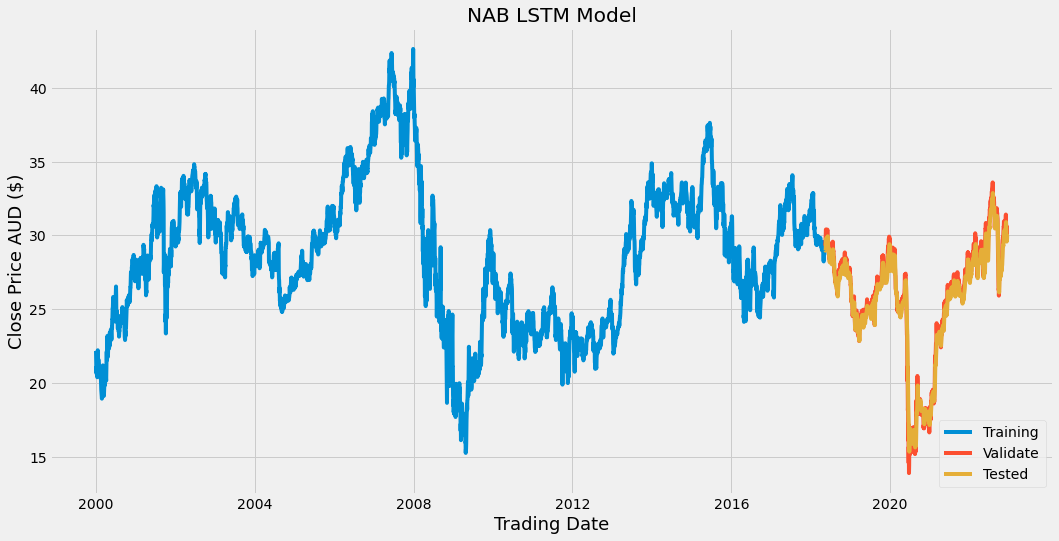

In [26]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('NAB LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/nab_graph.png')
plt.show()


# Test data Predictions on the Model

In [27]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_23944/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4591,29.299999,28.997938,0.302061
4592,29.379999,28.974852,0.405147
4593,29.520000,28.968163,0.551837
4594,29.780001,29.031277,0.748724
4595,30.180000,29.203337,0.976663
...,...,...,...
5733,30.010000,29.801668,0.208332
5734,30.299999,29.585278,0.714722
5735,30.610001,29.701632,0.908369
5736,29.840000,29.998755,-0.158754


In [28]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.nab.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [29]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [30]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

30/08/2022 Last close $29.989999771118164 Predicted next day share price $29.5


# Save the Model

In [31]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/nab_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list nab_sixty and load df

#PREDICT USING LOADED MODEL

In [32]:
from keras.models import load_model
model_in = load_model('../static/nab_model.sav')

In [33]:

# query the nab collection and load into dataframe
import pandas as pd

df_mongo = pd.DataFrame(list(db.nab.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[30.059999  ],
       [28.84      ],
       [27.879999  ],
       [28.045     ],
       [26.4       ],
       [26.309999  ],
       [26.219999  ],
       [25.43      ],
       [25.950001  ],
       [26.42      ],
       [26.809999  ],
       [27.09      ],
       [26.870001  ],
       [27.540001  ],
       [27.559999  ],
       [27.67      ],
       [27.389999  ],
       [27.51      ],
       [27.690001  ],
       [27.469999  ],
       [27.75      ],
       [27.85      ],
       [28.01      ],
       [27.66      ],
       [27.950001  ],
       [28.049999  ],
       [28.17      ],
       [27.790001  ],
       [28.549999  ],
       [29.        ],
       [29.530001  ],
       [29.52      ],
       [29.469999  ],
       [29.790001  ],
       [29.674999  ],
       [29.65      ],
       [30.18      ],
       [30.440001  ],
       [30.049999  ],
       [30.37000084],
       [30.42000008],
       [30.78000069],
       [30.71999931],
       [30.60000038],
       [29.36000061],
       [29

In [34]:
from keras.models import load_model
model_in = load_model('../static/nab_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_nab(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_nab(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[29.78,
 29.76,
 29.73,
 29.69,
 29.65,
 29.61,
 29.56,
 29.51,
 29.48,
 29.45,
 29.43,
 29.4,
 29.38,
 29.37,
 29.36,
 29.35,
 29.33,
 29.32,
 29.3,
 29.29,
 29.28,
 29.26,
 29.25,
 29.23,
 29.22,
 29.21,
 29.2,
 29.19,
 29.2,
 29.22,
 29.24,
 29.25,
 29.26,
 29.27,
 29.28,
 29.29,
 29.3,
 29.3,
 29.31,
 29.31,
 29.32,
 29.32,
 29.33,
 29.33,
 29.34,
 29.34,
 29.35,
 29.35,
 29.36,
 29.36,
 29.37,
 29.37,
 29.37,
 29.37,
 29.37,
 29.37,
 29.37,
 29.37,
 29.36,
 29.36,
 29.36,
 29.36,
 29.35,
 29.35,
 29.35,
 29.35,
 29.35,
 29.35,
 29.34,
 29.34,
 29.34,
 29.34,
 29.34,
 29.33,
 29.33,
 29.33,
 29.33,
 29.33,
 29.33,
 29.32,
 29.32,
 29.32,
 29.32,
 29.32,
 29.32,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.31,
 29.32,
 29.32,
 29.32,
 29.32,
 29.32,
 29.32,
 29.32,
 29.32,
 29.32,
 29.32,
 29.32

In [35]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  31-08-2022  Wednesday
1        2  01-09-2022   Thursday
2        3  02-09-2022     Friday
3        4  05-09-2022     Monday
4        5  06-09-2022    Tuesday
..     ...         ...        ...
203    204  12-06-2023     Monday
204    205  13-06-2023    Tuesday
205    206  14-06-2023  Wednesday
206    207  15-06-2023   Thursday
207    208  16-06-2023     Friday

[208 rows x 3 columns]>


In [36]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')

#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')
today_str=today1.strftime('%d-%m-%Y')
print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()
    records=dates_df.to_dict('records')
    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)
    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[10:].values
    print(dates_val)

2022-08-31 00:00:00 2022-08-30 00:00:00
5:15:33.359148
[[ObjectId('630dc684ae0967d012939261') 11 '14-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d012939262') 12 '15-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d012939263') 13 '16-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d012939264') 14 '19-09-2022' 'Monday']
 [ObjectId('630dc684ae0967d012939265') 15 '20-09-2022' 'Tuesday']
 [ObjectId('630dc684ae0967d012939266') 16 '21-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d012939267') 17 '22-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d012939268') 18 '23-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d012939269') 19 '26-09-2022' 'Monday']
 [ObjectId('630dc684ae0967d01293926a') 20 '27-09-2022' 'Tuesday']
 [ObjectId('630dc684ae0967d01293926b') 21 '28-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d01293926c') 22 '29-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d01293926d') 23 '30-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d01293926e') 24 '03-10-2022' 'Monday']
 [ObjectId('630dc6

C:\Users\antoi\AppData\Local\Temp/ipykernel_23944/2351677841.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


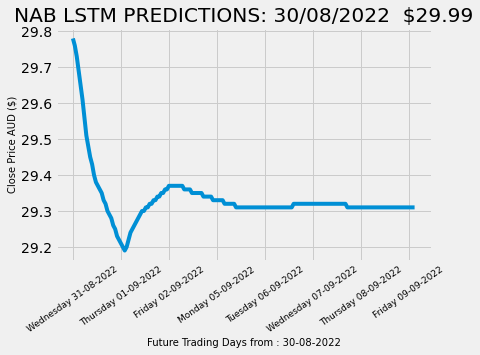

In [37]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,3]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,3]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,3]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,3]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,3]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,3]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,3]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,3]+" "+dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input-1]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title("NAB LSTM PREDICTIONS: "+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days from : '+today, fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/nab_pred.png', bbox_inches="tight")
plt.show()


In [38]:
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 29.78},
 {'Price': 29.76},
 {'Price': 29.73},
 {'Price': 29.69},
 {'Price': 29.65},
 {'Price': 29.61},
 {'Price': 29.56},
 {'Price': 29.51},
 {'Price': 29.48},
 {'Price': 29.45},
 {'Price': 29.43},
 {'Price': 29.4},
 {'Price': 29.38},
 {'Price': 29.37},
 {'Price': 29.36},
 {'Price': 29.35},
 {'Price': 29.33},
 {'Price': 29.32},
 {'Price': 29.3},
 {'Price': 29.29},
 {'Price': 29.28},
 {'Price': 29.26},
 {'Price': 29.25},
 {'Price': 29.23},
 {'Price': 29.22},
 {'Price': 29.21},
 {'Price': 29.2},
 {'Price': 29.19},
 {'Price': 29.2},
 {'Price': 29.22},
 {'Price': 29.24},
 {'Price': 29.25},
 {'Price': 29.26},
 {'Price': 29.27},
 {'Price': 29.28},
 {'Price': 29.29},
 {'Price': 29.3},
 {'Price': 29.3},
 {'Price': 29.31},
 {'Price': 29.31},
 {'Price': 29.32},
 {'Price': 29.32},
 {'Price': 29.33},
 {'Price': 29.33},
 {'Price': 29.34},
 {'Price': 29.34},
 {'Price': 29.35},
 {'Price': 29.35},
 {'Price': 29.36},
 {'Price': 29.36},
 {'Price': 29.37},
 {'Price': 29.37},
 {'Price': 29.37},

In [39]:
# len_df_mongo = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,len_df_mongo,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4591 5738 5898


,Close
5887,29.31
5888,29.31
5889,29.31
5890,29.31
5891,29.31
5892,29.31
5893,29.31
5894,29.31
5895,29.31
5896,29.31


C:\Users\antoi\AppData\Local\Temp/ipykernel_23944/3198281189.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


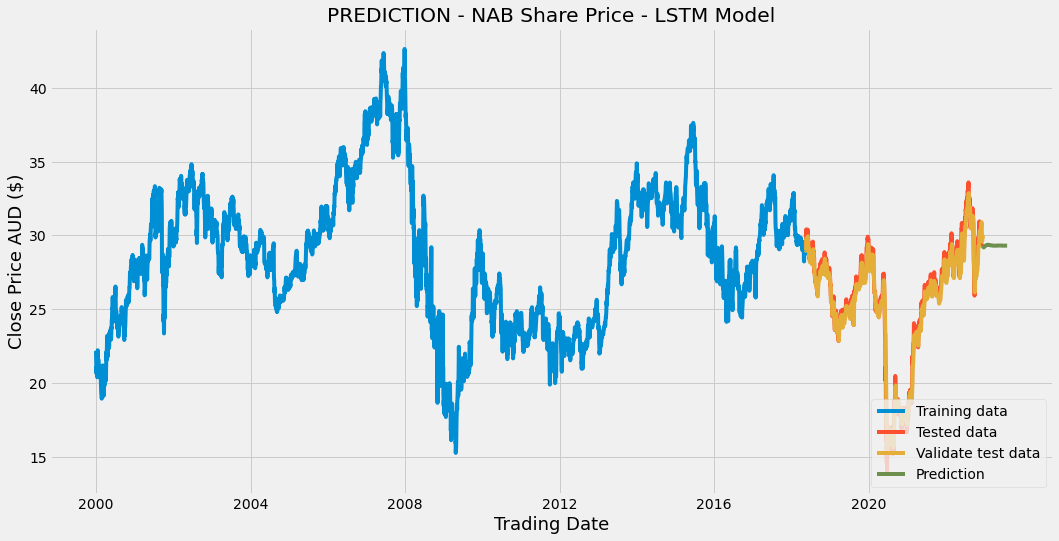

In [40]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION - NAB Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/nab_predict_graph.png')
plt.show()

#Save predicted error to MongoDB

In [41]:
# Query all
name = 'NAB'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)


{'_id': ObjectId('62f869ba3bc6ea83a205aea8'), 'model': 'RFR', 'name': 'NAB', 'date': '12/08/2022', 'predicted': 28, 'actual': 30, 'difference': -1.8976, 'accuracy': 97.17}
{'_id': ObjectId('630c942c97d791937f1832cd'), 'model': 'LSTM', 'name': 'NAB', 'date': '29/08/2022', 'predicted': 29.84, 'actual': 29.84, 'difference': 0.0, 'rmse': 0.14082}


In [42]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f869ba3bc6ea83a205aea8'), 'model': 'RFR', 'name': 'NAB', 'date': '12/08/2022', 'predicted': 28, 'actual': 30, 'difference': -1.8976, 'accuracy': 97.17}


In [43]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_close},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 29.99,predicted $29.5, actual $29.99, difference -0.48999999999999844, rmse 0.23854


In [44]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f869ba3bc6ea83a205aea8'), 'model': 'RFR', 'name': 'NAB', 'date': '12/08/2022', 'predicted': 28, 'actual': 30, 'difference': -1.8976, 'accuracy': 97.17}
{'_id': ObjectId('630dcdeb0a29fd36804fc140'), 'model': 'LSTM', 'name': 'NAB', 'date': '30/08/2022', 'predicted': 29.5, 'actual': 29.99, 'difference': -0.49, 'rmse': 0.23854}


In [45]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'